# Analysis functions

In [29]:
import numpy as np
import matplotlib.pyplot as plt
import re
import pandas as pd

color_scheme = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd',
                               '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
#Helper funtions
def to_seconds(time_series):
  split_string = lambda timestring: re.split(':', timestring)
  time = [float(split_string(value)[0])*3600 + float(split_string(value)[1])*60 + float(split_string(value)[2]) for value in time_series]
  return time


def timeToSec(time):
    pc = re.split(':',time)
    return int(pc[0])*3600 + int(pc[1])*60 + int(pc[2])
  
def completion_at_time(data,
                      control_data,
                      casc_data,
                      time_list_seconds,
                      time_in_seconds,
                      conditions,
                      control_conditions,
                      casc_conditions,
                      base_line_level,
                      triggered_level,
                      experimental_level,
                      verbose = False):
  data = data
  conditions = conditions
  control_data = control_data
  control_conditions = control_conditions

  def progegate_uncertainty_averaged_stddev(std_dev_list):
    return np.sqrt(sum(s**2 for s in std_dev_list)/(len(std_dev_list)**2))

  def average_last_n_with_std(n, average_series, std_series):
    av = average_series[-n:].mean()
    std = progegate_uncertainty_averaged_stddev(std_series[-n:].values)
    return av, std
  def calculate_completion_level(V, T, B):
    return (float(V) - float(B))/(float(T) - float(B))
  def series_av_and_std(dat, cond, level_name):
    target_columns = cond[level_name]
    dat[target_columns] = dat[target_columns].apply(pd.to_numeric)
    average_by_point = dat[target_columns].mean(axis=1)
    std_by_point = dat[target_columns].std(axis=1)
    return average_by_point, std_by_point

  #Get the x-values in seconds
  x = time_list_seconds
  #Fine the index of the first datapoint greater than time in seconds
  desired_time_index = min([i for i, time in enumerate(x) if time >= time_in_seconds])
  #Fist calculate baseline average and uncertainty at LAST AVAILABLE 5 DATAPOINTS
  base_line_average, base_line_std = average_last_n_with_std(5, *series_av_and_std(control_data, control_conditions, base_line_level))
  #Next calculate the triggering average and uncerainty at LAST 5 AVAILABLE DATAPOINTS
  triggered_average, triggered_std = average_last_n_with_std(5, *series_av_and_std(casc_data, casc_conditions, triggered_level))
  completion_levels = []
  for l_name in conditions[experimental_level]:
    completion_levels += [calculate_completion_level(data[l_name][desired_time_index], triggered_average, base_line_average)]

  if verbose:
    print(f"{experimental_level} : {np.average(completion_levels)} +/- {np.std(completion_levels)}")
  return np.average(completion_levels), np.std(completion_levels)



# Importing data

In [30]:
UW_leak = pd.read_csv("UW_Cascades.csv")
conditions_UW_leak = {'no_incubation F0(mm)_2uM_cal: 30.0 nM, F1(mm)_2uM_cal: 30.0 nM, F2(mm)_2uM_cal: 30.0 nM, R1_1uM_cal: 40.0 nM' : ['B10', 'C10', 'D10'],
             'no_incubation F0(mm)_2uM_cal: 30.0 nM, F1(mm)_2uM_cal: 30.0 nM, F2(mm)_2uM_cal: 30.0 nM, N50_80uM: 25000.0 nM, R1_1uM_cal: 40.0 nM' : ['B12', 'C12', 'D12'],
             'no_incubation F0nn_1uM_cal: 30.0 nM, F1nn_1uM_cal: 30.0 nM, F2nn_1uM_cal: 30.0 nM, R1(nn)_1uM_cal: 40.0 nM' : ['E10', 'F10', 'G10'],
             'no_incubation F0nn_1uM_cal: 30.0 nM, F1nn_1uM_cal: 30.0 nM, F2nn_1uM_cal: 30.0 nM, N50_80uM: 25000.0 nM, R1(nn)_1uM_cal: 40.0 nM' : ['E12', 'F12', 'G12']}
offset_UW_leak = 190
t_UW_leak = [timeToSec(t) + offset_UW_leak for t in UW_leak['Time'].values]

TUM_leak = pd.read_csv("TUM_Cascade_Leak")
conditions_TUM_leak = {'nat leak' : ['R + G3 + G2 + G1'],
                      'nn leak' : ['nn R + G3 + G2 + G1']}
offset_TUM_leak = 0
t_TUM_leak = [int(t) + offset_TUM_leak for t in TUM_leak['time'].values]

# Processing TUM data

In [37]:
fit_nat = [3862.000000, (18790.666667-3862.000000)/20]
fit_nn =  [3997.033333, (18162.900000-3997.033333)/20]
fits = [fit_nat, fit_nn]

Completion increse (labels[i]): 6.959764211875144 %
Completion increse (labels[i]): 4.256710967107396 %


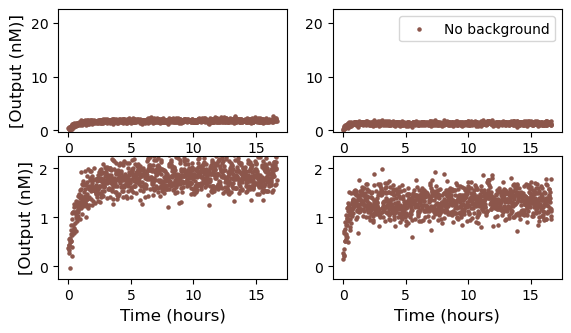

In [38]:
def series_av_and_std(dat, cond, level_name):
  target_columns = cond[level_name]
  dat[target_columns] = dat[target_columns].apply(pd.to_numeric)
  average_by_point = dat[target_columns].mean(axis=1)
  std_by_point = dat[target_columns].std(axis=1)
  return average_by_point, std_by_point

def normalize_av_and_std(av, std, fit):
  new_av = (av - fit[0])/ fit[1]
  new_std = np.sqrt((std/fit[1])**2 )
  return new_av, new_std

fig,ax = plt.subplots(2,2)
fig.set_figwidth(6.5)
fig.set_figheight(3.5)

t = [i/3600 for i in t_TUM_leak]
data = TUM_leak
conditions = conditions_TUM_leak

levels = list(conditions.keys())

labels = ['No background', 'N50 25uM']
for i,l in enumerate(levels):
  y, std = normalize_av_and_std(*series_av_and_std(data, conditions, l), fits[i])
  print(f"Completion increse (labels[i]): {100*(y[len(y)-1] - y[0])/20} %")

  y = np.array(y)
  std = np.array(std)
  ax[0][i].scatter(t, y, color= color_scheme[5], s = 5, label = labels[0])
  ax[0][i].fill_between(t, y- std, y + std, color= color_scheme[5], alpha = 0.3)
  ax[0][i].set_ylim(-0.25, 22.5)
  ax[0][i].set_xlabel('Time (hours)', fontsize = 12)

ax[0][0].set_ylabel('[Output (nM)]', fontsize = 12)
ax[0][1].legend()


for i,l in enumerate(levels):
  y, std = normalize_av_and_std(*series_av_and_std(data, conditions, l), fits[i])

  y = np.array(y)
  std = np.array(std)
  ax[1][i].scatter(t, y, color= color_scheme[5], s = 5, label = labels[0])
  ax[1][i].fill_between(t, y- std, y + std, color= color_scheme[5], alpha = 0.3)
  ax[1][i].set_ylim(-0.25, 2.25)
  ax[1][i].set_xlabel('Time (hours)', fontsize = 12)

ax[1][0].set_ylabel('[Output (nM)]', fontsize = 12)

#plt.savefig('5th_leak.svg', dpi =400)
plt.show()

# Processing UW data

## No incubation

In [39]:

fit_nat = [789.333333, (6299.700000 - 789.333333)/20]
fit_nn =  [278.600000		, (4571.900000	- 278.600000	)/20]

fit_nat2 = [870.766667, (6299.700000 - 870.766667)/20]
fit_nn2 =  [330.533333		, (4571.900000	- 330.533333	)/20]
fits = [[fit_nat, fit_nn], [fit_nat2, fit_nn2]]


Completion increse (labels[i]): 0.7077568945377043 %
Completion increse (labels[i]): 0.9885305892494853 %
Completion increse (labels[i]): 1.0248526774276205 %
Completion increse (labels[i]): 0.6365872634892381 %


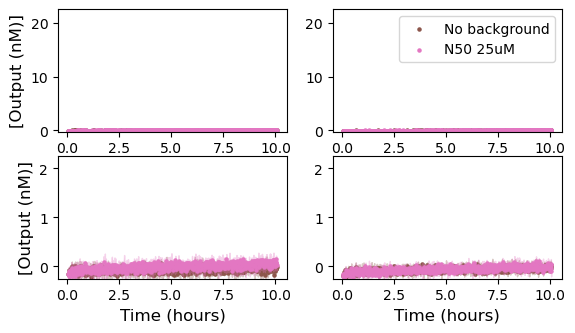

In [40]:
def series_av_and_std(dat, cond, level_name):
  target_columns = cond[level_name]
  dat[target_columns] = dat[target_columns].apply(pd.to_numeric)
  average_by_point = dat[target_columns].mean(axis=1)
  std_by_point = dat[target_columns].std(axis=1)
  return average_by_point, std_by_point

def normalize_av_and_std(av, std, fit):
  new_av = (av - fit[0])/ fit[1]
  new_std = np.sqrt((std/fit[1])**2 )
  return new_av, new_std

fig,ax = plt.subplots(2,2)
fig.set_figwidth(6.5)
fig.set_figheight(3.5)

t = [i/3600 for i in t_UW_leak]
data = UW_leak
conditions = conditions_UW_leak

levels = list(conditions.keys())

labels = ['No background', 'N50 25uM']
for i,l in enumerate(levels):
  y, std = normalize_av_and_std(*series_av_and_std(data, conditions, l), fits[i%2][i//2])
  print(f"Completion increse (labels[i]): {100*(y[len(y)-1] - y[0])/20} %")


  y = np.array(y)
  std = np.array(std)
  ax[0][i//2].scatter(t, y, color= color_scheme[i%2 + 5], s = 5, label = labels[i%2])
  ax[0][i//2].fill_between(t, y- std, y + std, color= color_scheme[i%2 + 5], alpha = 0.3)
  ax[0][i//2].set_ylim(-0.25, 22.5)
  ax[0][i//2].set_xlabel('Time (hours)', fontsize = 12)

ax[0][0].set_ylabel('[Output (nM)]', fontsize = 12)
ax[0][1].legend()


for i,l in enumerate(levels):
  y, std = normalize_av_and_std(*series_av_and_std(data, conditions, l), fits[i%2][i//2])

  y = np.array(y)
  std = np.array(std)
  ax[1][i//2].scatter(t, y, color= color_scheme[i%2 + 5], s = 5, label = labels[i%2])
  ax[1][i//2].fill_between(t, y- std, y + std, color= color_scheme[i%2 + 5], alpha = 0.3)
  ax[1][i//2].set_ylim(-0.25, 2.25)
  ax[1][i//2].set_xlabel('Time (hours)', fontsize = 12)

ax[1][0].set_ylabel('[Output (nM)]', fontsize = 12)

#plt.savefig('3th_leak.svg', dpi =400)
plt.show()